Ichijo_cdno1_preprocessed.csvとdataフォルダ、figuresフォルダで動くはず

In [117]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [118]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [119]:
print(tf.__version__)

2.17.1


In [120]:
tf.random.set_seed(42)
np.random.seed(42)

In [121]:
#ここをサンプルのcdnoに
df = pd.read_csv('Ichijo_cdno1_preprocessed.csv')
df.head()

,date_time,n_main_generation,n_main_consumption,n_main_buy,n_main_sell,n_main_generated_at_home,n_hems_light,n_hems_air_conditioner,n_hems_eco_cute,n_hems_ih,n_hems_fridge,n_hems_washing,n_hems_ev
0,2020-01-01 00:00:00,0,0,380,0,0,357,0,0,14,0,0,0
1,2020-01-01 01:00:00,0,0,142,0,0,0,320,191,28,0,0,0
2,2020-01-01 02:00:00,0,194,1971,0,0,459,340,0,0,0,0,0
3,2020-01-01 03:00:00,0,634,0,0,0,146,172,333,247,0,0,0
4,2020-01-01 04:00:00,0,181,1836,0,0,141,0,2127,381,0,0,0


In [122]:
df.tail()

,date_time,n_main_generation,n_main_consumption,n_main_buy,n_main_sell,n_main_generated_at_home,n_hems_light,n_hems_air_conditioner,n_hems_eco_cute,n_hems_ih,n_hems_fridge,n_hems_washing,n_hems_ev
17539,2021-12-31 19:00:00,0,0,279,0,0,74,0,0,0,0,0,0
17540,2021-12-31 20:00:00,0,199,360,0,0,0,42,0,0,0,0,0
17541,2021-12-31 21:00:00,0,212,627,0,0,11,0,1003,173,0,0,0
17542,2021-12-31 22:00:00,0,0,267,0,0,8,156,0,135,0,0,0
17543,2021-12-31 23:00:00,0,0,293,0,0,57,366,0,0,0,0,0


In [123]:
df.shape

(17544, 13)

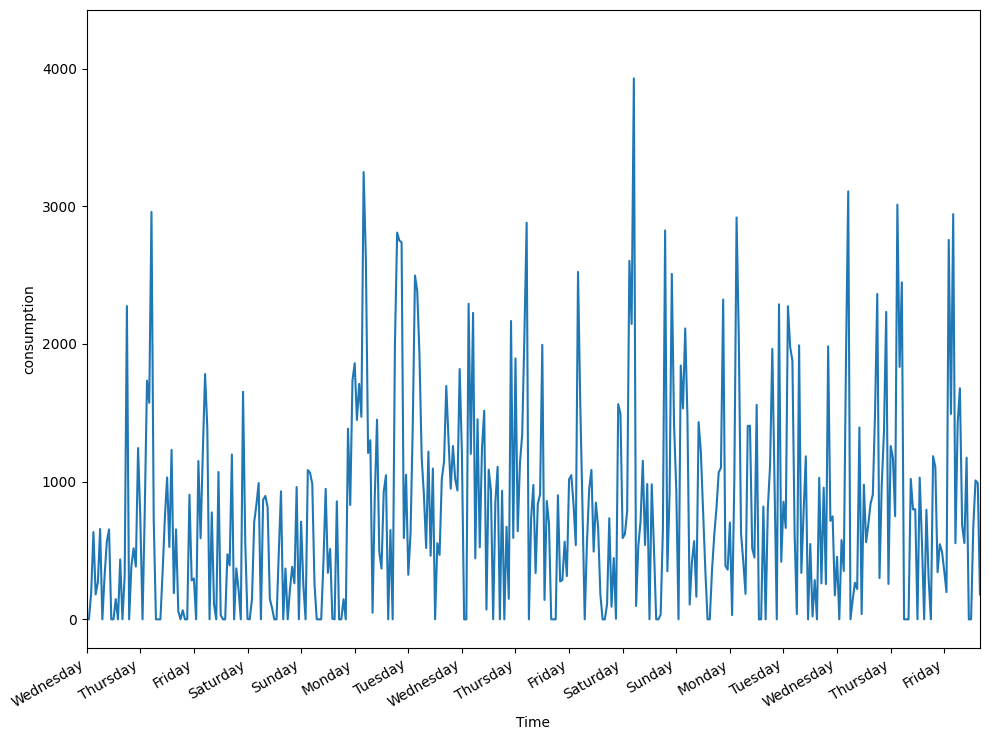

In [124]:
fig, ax = plt.subplots()

ax.plot(df['n_main_consumption'])
ax.set_xlabel('Time')
ax.set_ylabel('consumption')

plt.xticks(np.arange(0, 400, 24), ['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/test.png', dpi=300)

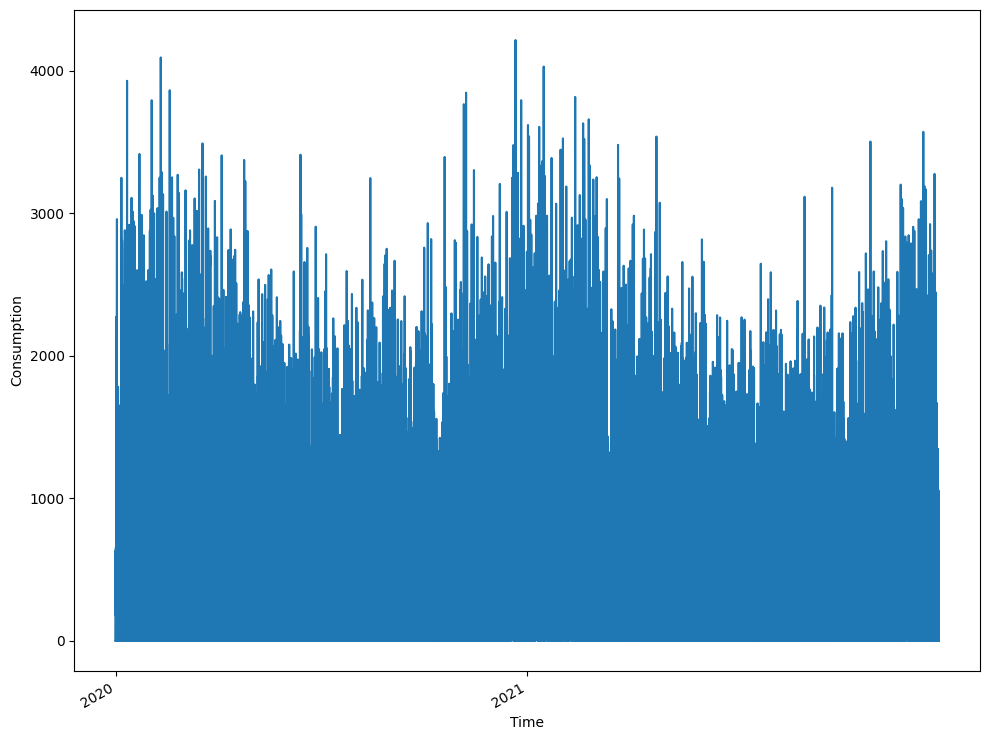

In [125]:
fig, ax = plt.subplots()

ax.plot(df['n_main_consumption'])
ax.set_xlabel('Time')
ax.set_ylabel('Consumption')

plt.xticks([0, 8760], [2020, 2021])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/test-2.png', dpi=300)

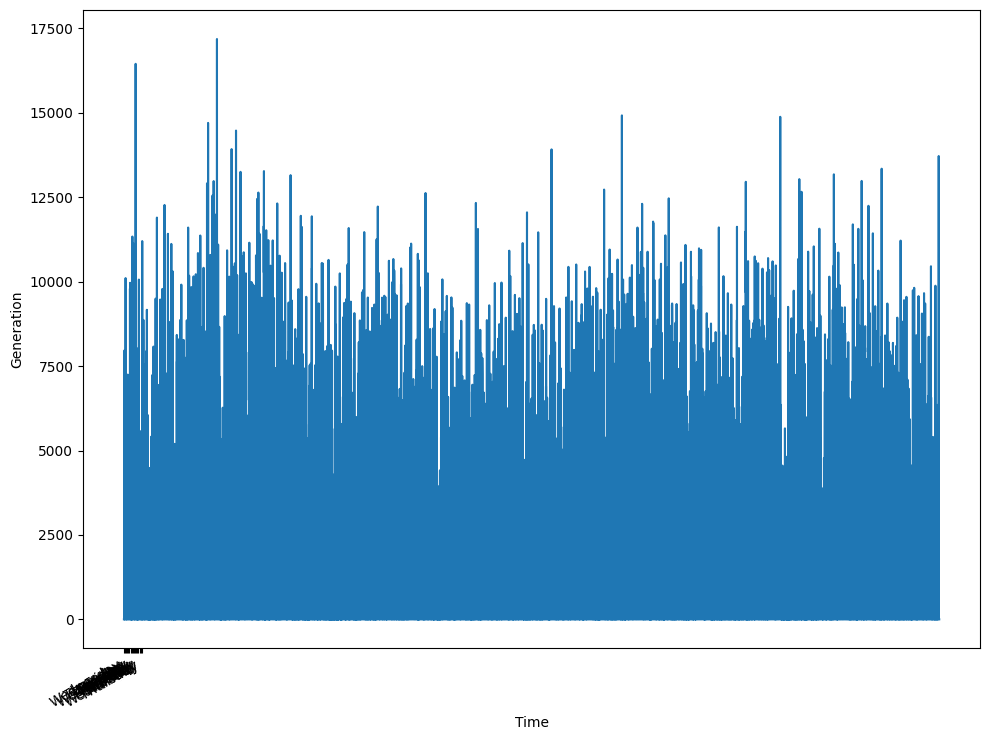

In [126]:
fig, ax = plt.subplots()

ax.plot(df['n_main_generation'])
ax.set_xlabel('Time')
ax.set_ylabel('Generation')

plt.xticks(np.arange(0, 400, 24), ['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/test_3', dpi=300)

In [127]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_main_generation,17544.0,1616.546854,2641.328364,0.0,0.00,0.0,2744.25,17188.0
n_main_consumption,17544.0,714.774909,673.693075,0.0,97.75,597.0,1108.00,4215.0
n_main_buy,17544.0,517.152816,707.372193,0.0,0.00,81.0,905.00,4212.0
n_main_sell,17544.0,1398.023085,2430.674566,0.0,0.00,0.0,2184.25,14785.0
n_main_generated_at_home,17544.0,214.059679,334.782970,0.0,0.00,0.0,378.00,2052.0
n_hems_light,17544.0,290.570508,219.518945,0.0,111.00,271.0,435.25,1635.0
n_hems_air_conditioner,17544.0,141.393753,178.533372,0.0,0.00,63.0,242.00,1256.0
n_hems_eco_cute,17544.0,270.754503,464.077254,0.0,0.00,0.0,389.00,3049.0
n_hems_ih,17544.0,66.514250,97.765717,0.0,0.00,14.0,108.00,1045.0
n_hems_fridge,17544.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


In [128]:
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

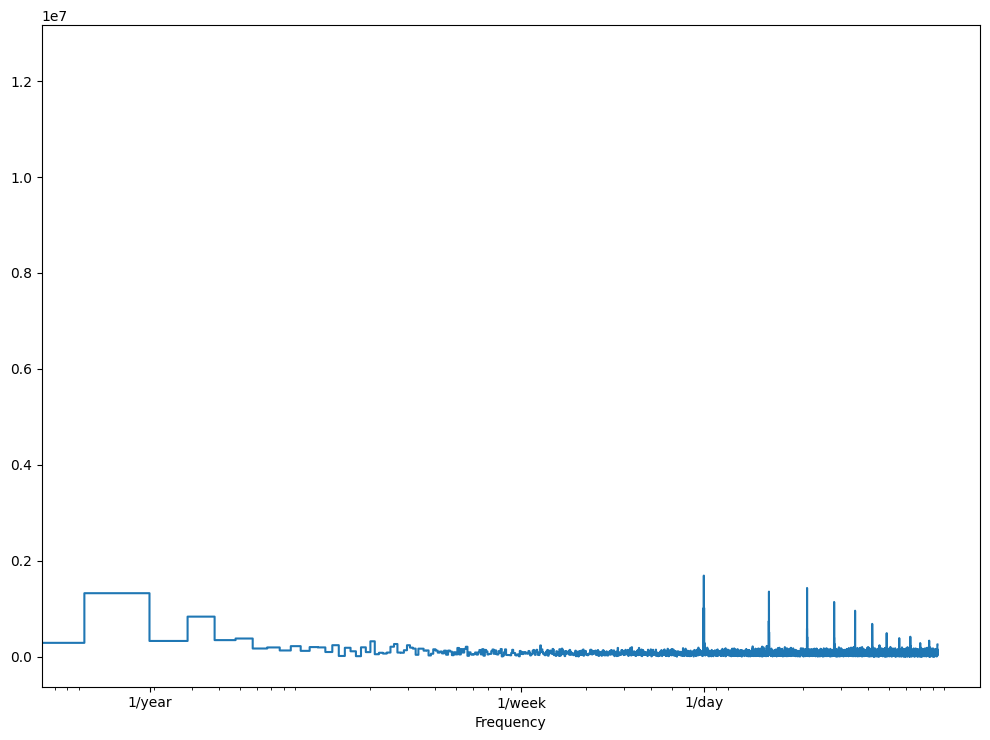

In [129]:
fft = tf.signal.rfft(df['n_main_consumption'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['n_main_consumption'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1/52, 1, 7], ['1/year', '1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

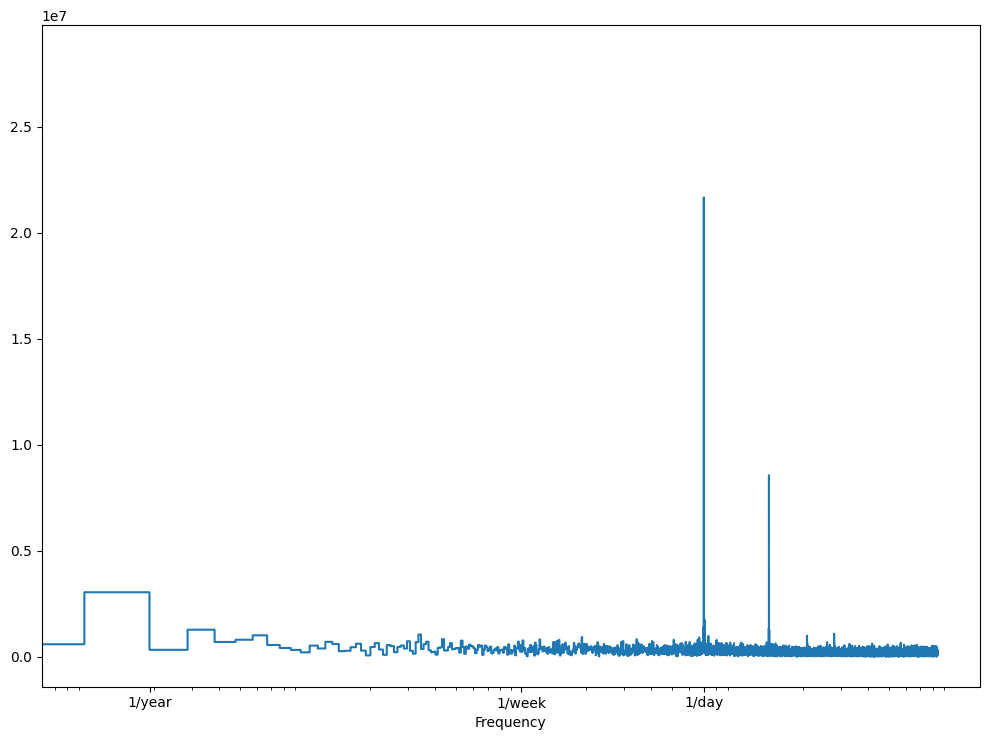

In [130]:
fft = tf.signal.rfft(df['n_main_generation'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['n_main_generation'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1/52, 1, 7], ['1/year', '1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

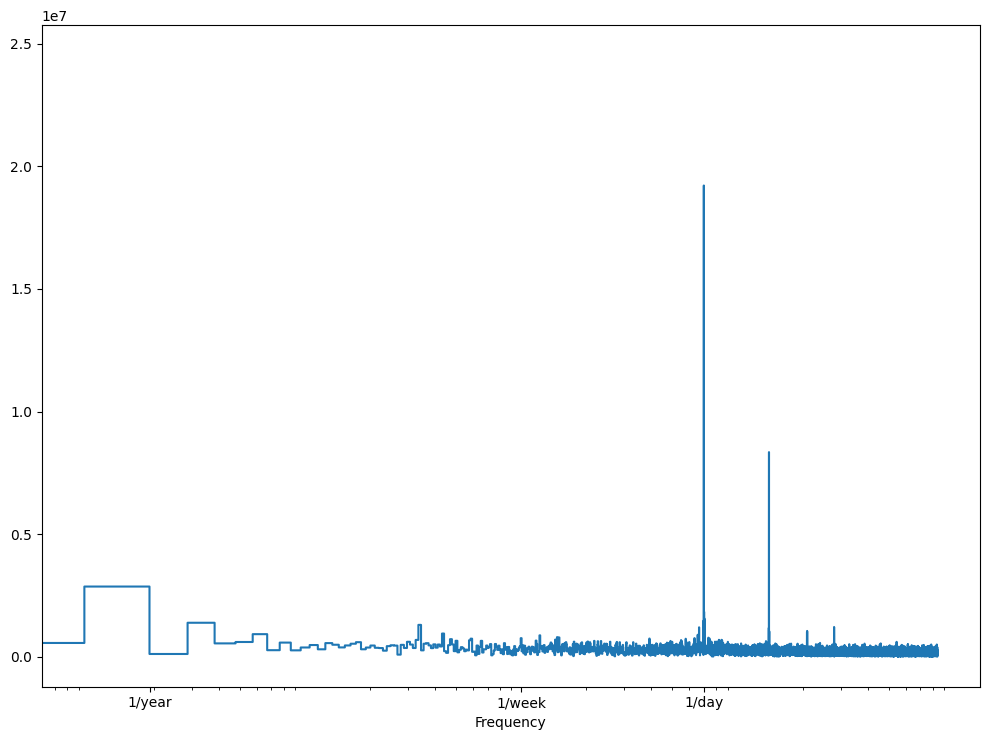

In [131]:
fft = tf.signal.rfft(df['n_main_sell'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['n_main_sell'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1/52, 1, 7], ['1/year', '1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

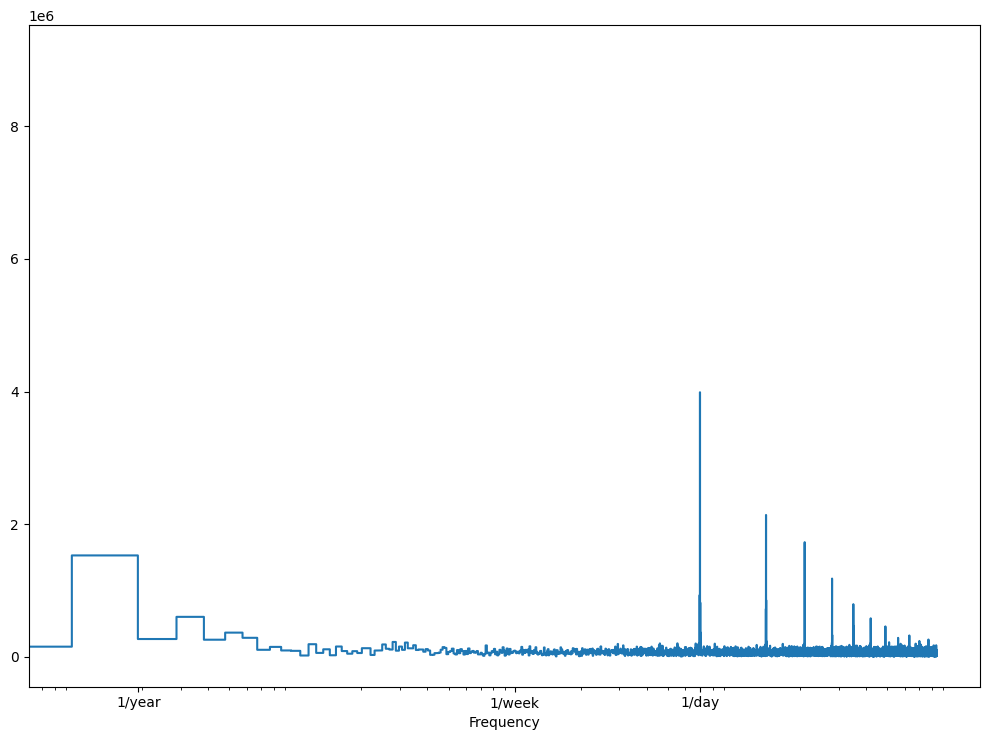

In [132]:
fft = tf.signal.rfft(df['n_main_buy'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['n_main_buy'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1/52, 1, 7], ['1/year', '1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

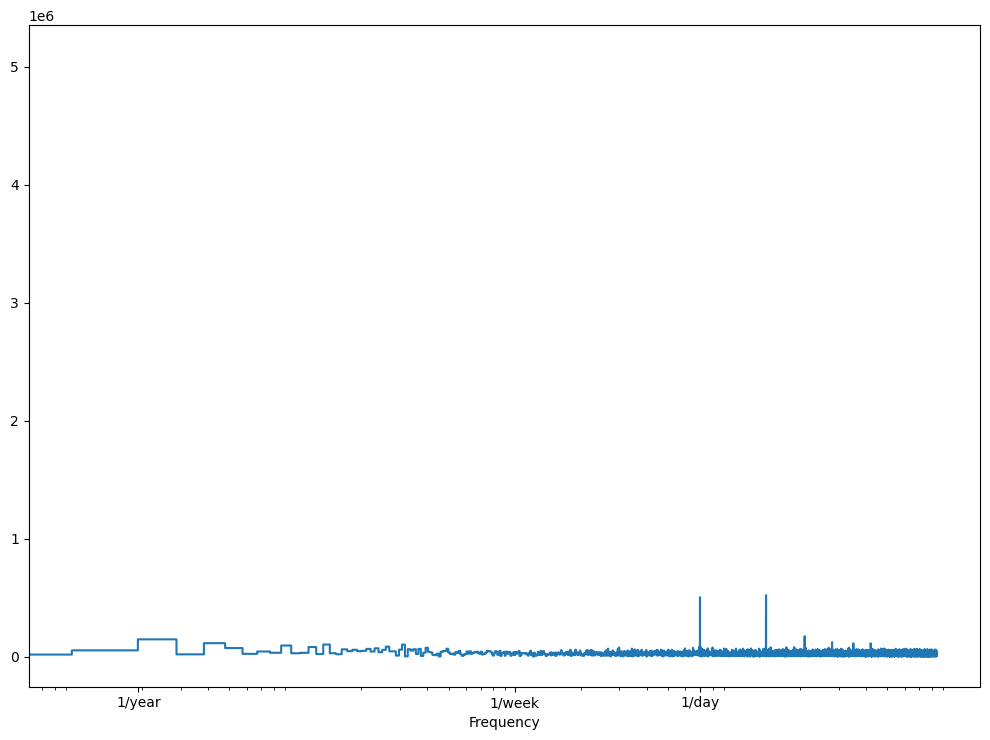

In [133]:
fft = tf.signal.rfft(df['n_hems_light'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['n_hems_light'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1/52, 1, 7], ['1/year', '1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

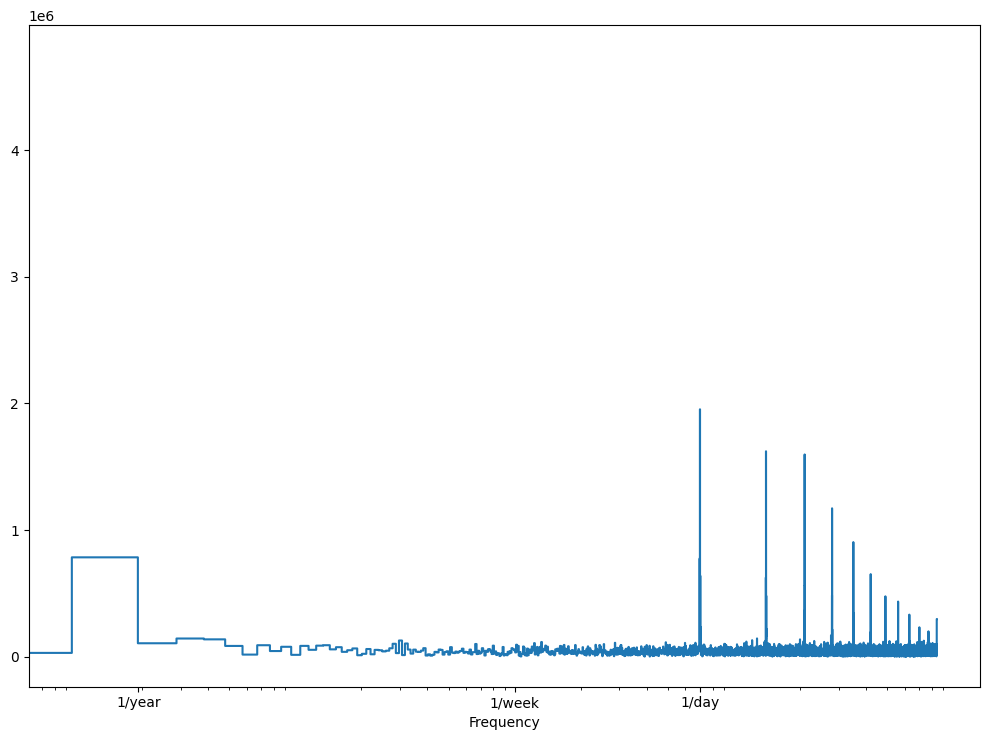

In [134]:
fft = tf.signal.rfft(df['n_hems_eco_cute'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['n_hems_eco_cute'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1/52, 1, 7], ['1/year', '1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

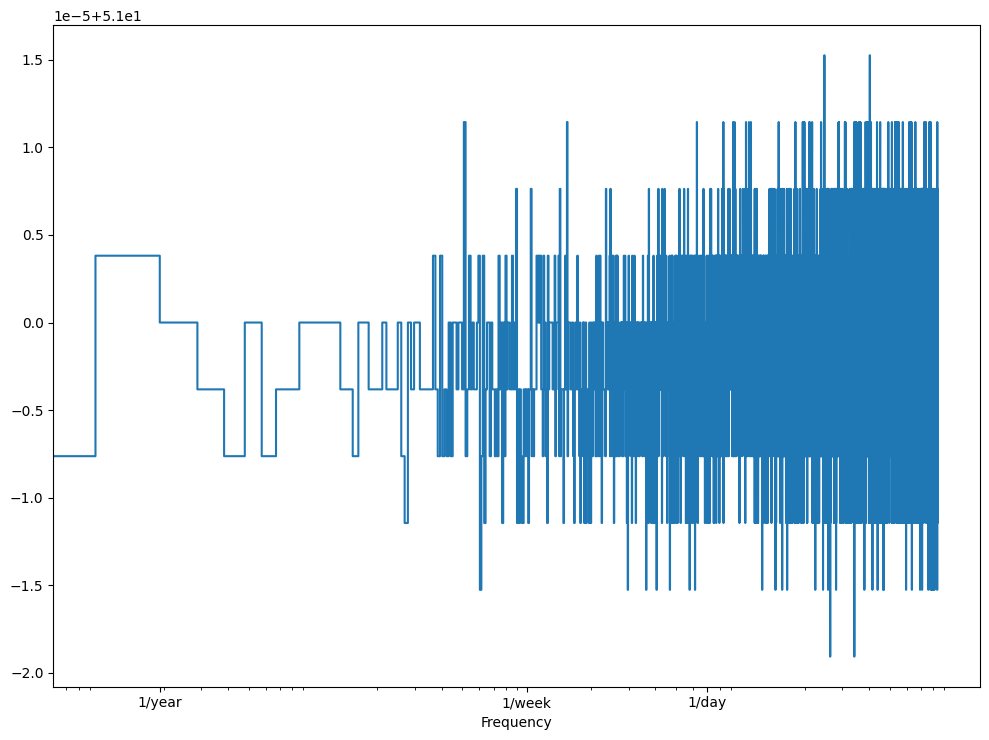

In [135]:
fft = tf.signal.rfft(df['n_hems_ev'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['n_hems_ev'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1/52, 1, 7], ['1/year', '1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [136]:
day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [137]:
df = df.drop(['date_time'], axis=1)

df.head()

,n_main_generation,n_main_consumption,n_main_buy,n_main_sell,n_main_generated_at_home,n_hems_light,n_hems_air_conditioner,n_hems_eco_cute,n_hems_ih,n_hems_fridge,n_hems_washing,n_hems_ev,day_sin,day_cos
0,0,0,380,0,0,357,0,0,14,0,0,0,-7.670342e-12,1.000000
1,0,0,142,0,0,0,320,191,28,0,0,0,2.588190e-01,0.965926
2,0,194,1971,0,0,459,340,0,0,0,0,0,5.000000e-01,0.866025
3,0,634,0,0,0,146,172,333,247,0,0,0,7.071068e-01,0.707107
4,0,181,1836,0,0,141,0,2127,381,0,0,0,8.660254e-01,0.500000


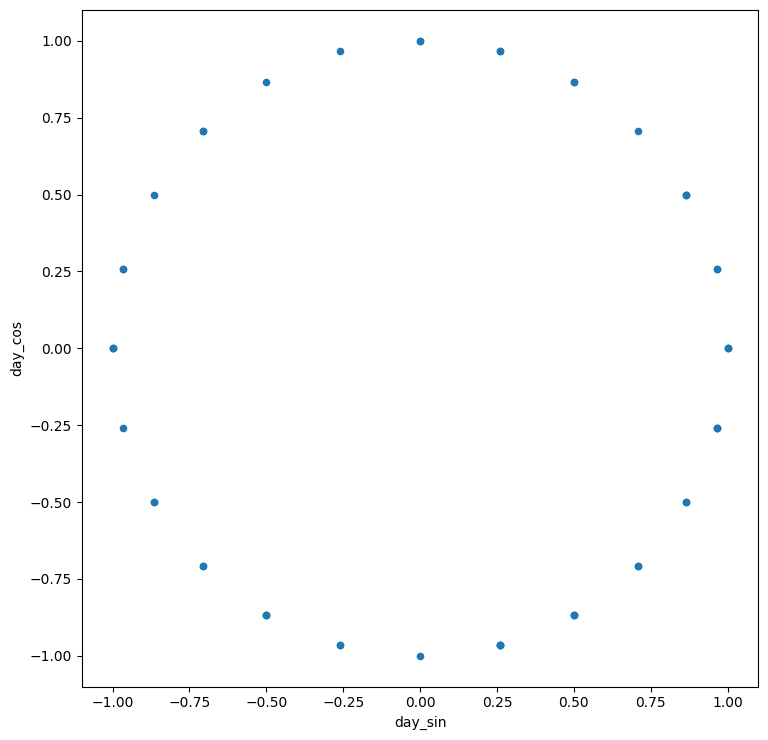

In [138]:
df.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');
plt.tight_layout()

plt.savefig('figures/test-4.png', dpi=300)

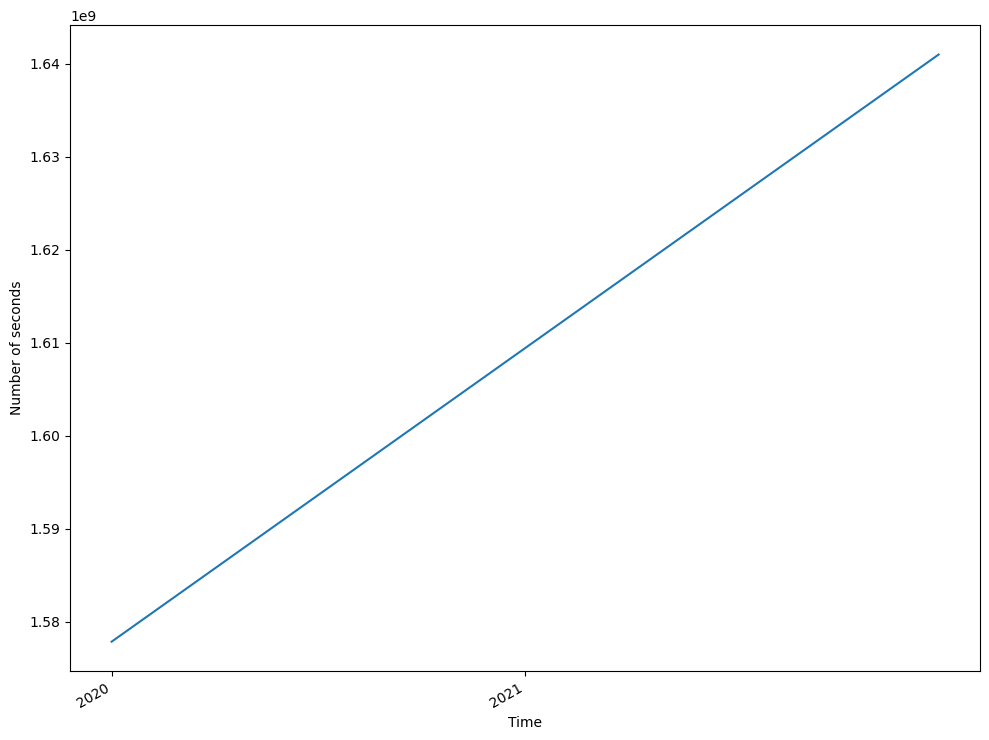

In [139]:
fig, ax = plt.subplots()

ax.plot(timestamp_s)
ax.set_xlabel('Time')
ax.set_ylabel('Number of seconds')

plt.xticks([0, 8760], [2020, 2021])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/test-5.png', dpi=300)

In [140]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((12280, 14), (3509, 14), (1755, 14))

In [141]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [142]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_main_generation,12280.0,0.095732,0.155957,0.0,0.000000,0.000000,0.162381,1.0
n_main_consumption,12280.0,0.176241,0.164603,0.0,0.027758,0.147805,0.271412,1.0
n_main_buy,12280.0,0.128444,0.172933,0.0,0.000000,0.027778,0.225546,1.0
n_main_sell,12280.0,0.096078,0.167018,0.0,0.000000,0.000000,0.152063,1.0
n_main_generated_at_home,12280.0,0.104650,0.163312,0.0,0.000000,0.000000,0.183723,1.0
n_hems_light,12280.0,0.231000,0.174331,0.0,0.088678,0.216152,0.346793,1.0
n_hems_air_conditioner,12280.0,0.122865,0.148653,0.0,0.000000,0.064490,0.211783,1.0
n_hems_eco_cute,12280.0,0.093534,0.158692,0.0,0.000000,0.000000,0.134470,1.0
n_hems_ih,12280.0,0.064941,0.095726,0.0,0.000000,0.013397,0.105263,1.0
n_hems_fridge,12280.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [143]:
#ここをサンプルのcdnoに
train_df.to_csv('data/Ichijo_cdno1_train.csv')
val_df.to_csv('data/Ichjo_cdno1_val.csv')
test_df.to_csv('data/Ichijo_cdno1_test.csv')

In [144]:
test_df

,n_main_generation,n_main_consumption,n_main_buy,n_main_sell,n_main_generated_at_home,n_hems_light,n_hems_air_conditioner,n_hems_eco_cute,n_hems_ih,n_hems_fridge,n_hems_washing,n_hems_ev,day_sin,day_cos
15789,0.0,0.153262,0.021368,0.0,0.0,0.233571,0.000000,0.000000,0.240191,0.0,0.0,0.0,0.146447,0.853553
15790,0.0,0.365836,0.000000,0.0,0.0,0.244656,0.037420,0.164972,0.029665,0.0,0.0,0.0,0.250000,0.933013
15791,0.0,0.311032,0.189221,0.0,0.0,0.482185,0.000000,0.000000,0.246890,0.0,0.0,0.0,0.370590,0.982963
15792,0.0,0.167972,0.235518,0.0,0.0,0.103721,0.017516,0.165628,0.000000,0.0,0.0,0.0,0.500000,1.000000
15793,0.0,0.037011,0.045584,0.0,0.0,0.079177,0.000000,0.000000,0.042105,0.0,0.0,0.0,0.629410,0.982963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,0.0,0.000000,0.066239,0.0,0.0,0.058591,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017037,0.629410
17540,0.0,0.047212,0.085470,0.0,0.0,0.000000,0.033439,0.000000,0.000000,0.0,0.0,0.0,0.066987,0.750000
17541,0.0,0.050297,0.148860,0.0,0.0,0.008709,0.000000,0.328960,0.165550,0.0,0.0,0.0,0.146447,0.853553
17542,0.0,0.000000,0.063390,0.0,0.0,0.006334,0.124204,0.000000,0.129187,0.0,0.0,0.0,0.250000,0.933013
